In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
#import seaborn as sns

## Plot PCA

In [58]:
counts = pd.read_csv('../data/BAL/Reseq_ALL/counts_reseq.csv', sep='\t', 
                     index_col='sample_id')
meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')

In [170]:
m = meta[meta['Uniquely mapped reads number']>20e6].index
d = counts.ix[m]

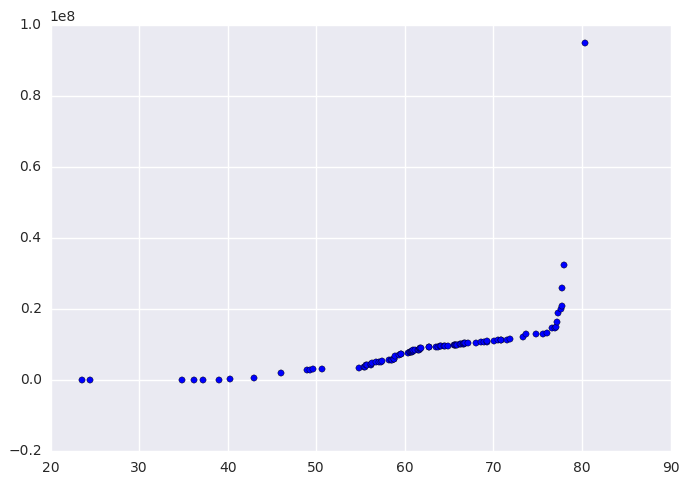

In [165]:
plt.scatter(sorted(meta['Uniquely mapped reads %']), sorted(meta['Uniquely mapped reads number']))

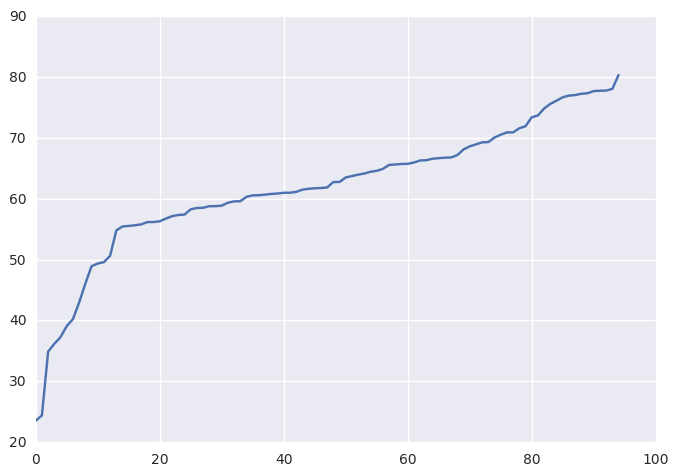

In [163]:
plt.plot(sorted(meta['Uniquely mapped reads %']))

In [27]:
## Filter 

In [144]:
min_uniques = 4e6
min_gene_count = 10 ## All genes from all samples must have 10 counts
## AM
def filter_norm(df, meta, celltype, min_gene_count=0, min_uniques=0):
    meta['Norm_Factor'] = meta['Uniquely mapped reads number'].map(lambda x: float(x) / np.median(meta['Uniquely mapped reads number']))
    bal_dict = dict(zip(meta.index,meta['Norm_Factor']))
    samples_min_unique = meta[meta['Uniquely mapped reads number'] > min_uniques].index
    df = df.ix[samples_min_unique].T
    for i in df.columns:
        norm_fac = meta.loc[i,'Norm_Factor']
        df[i] = df[i].map(lambda x: float(x)/norm_fac)
    df = df.T
    df = df.loc[:, df.min(axis=0) > min_gene_count]
    df = df.apply(lambda x: np.log2(x + 1))
    dfm = meta.ix[df.index]
    return df, dfm

In [136]:
counts.loc[:, counts.min(axis=0) > 0].shape

(95, 249)

In [133]:
counts.shape

(95, 58051)

In [214]:
def get_non_outlier_indices(df, n_stages=1, zcut=2):
    outlier_inds = []
    for i in range(n_stages):
        pca = PCA(n_components=4)
        pca_fit = pca.fit_transform(df)
        pc1, pc2, pc3 = pca_fit.T[0], pca_fit.T[1], pca_fit.T[2]
        z1, z2, z3 = zscore(pc1), zscore(pc2), zscore(pc3)
        #print pc1, z1
        n = len(z1)
        outlier_inds += [i for i in range(n) if abs(z1[i]) > zcut]
        outlier_inds += [i for i in range(n) if abs(z2[i]) > zcut and i not in outlier_inds]
        outlier_inds += [i for i in range(n) if abs(z3[i]) > zcut and i not in outlier_inds]
        for i in range(n):
            if pc1[i] > 20:
                print i, pc1[i], z1[i]
        non_outlier_inds = [i for i in range(n) if i not in outlier_inds]
        print outlier_inds
        df = df.ix[non_outlier_inds,]
    return non_outlier_inds

In [22]:
dfm = meta[meta['CellType']=='AM']
samples = dfm.index

In [23]:
df = counts.ix[samples]

In [57]:
meta['CellType'].unique()

array(['CD163', 'AM', '163'], dtype=object)

In [54]:
celltype='CD163'
dfm = meta[meta['CellType']==celltype]
dfm.shape

(16, 32)

In [187]:
def plot_pca(counts, meta, celltype, PCs=[1,2], color_label='Pneum', label_pseudomonas=False, 
             label_flu=False, size_col=None, size_scale=100, size_label=True, 
             limits=None, legend_loc='top_right', remove_outliers=False, z_score=True,
             min_gene_count=0, min_uniques=0):
    
    #plt.figure(figsize=(8,6))
    dfm = meta[meta['CellType']==celltype]
    df = counts.ix[dfm.index]
    print df.shape
    df, dfm = filter_norm(df, dfm, celltype, min_gene_count, min_uniques)
    print df.shape
    colors = {0: 'b', 1: 'orange'} 
    sizes = [size_scale for x in dfm.index]
    
    ### SIZE_COL designates the size of the points
    if size_col: 
        ### IMPUTE NANs by using mean
        dfm[size_col] = dfm[size_col].map(lambda x: np.mean(dfm[size_col]) if np.isnan(x) else x)
        ### Z-SCORE Results
        scores = zscore(dfm[size_col])
        scale = size_scale
        rng = 0.5 ## 50% variation in size
        sizes = [scale + scale*rng*i for i in scores]
    
    ### Run PCA, get labels
    
    ###
    PCi = [x-1 for x in PCs] # PC indices based on input (input PC1 -> PCi=0)
    
    #### Remove outliers
    if remove_outliers != 0:
        print "removing outliers"
        non_outlier_indices = get_non_outlier_indices(df, n_stages=remove_outliers)
        df = df.ix[non_outlier_indices,]
        dfm = dfm.ix[non_outlier_indices,]
        
    if z_score:
        #df = df.apply(zscore, axis=1)
        df = df.apply(zscore, axis=0)

    #### Re-do PCA with outliers removed    

    pca = PCA(n_components=4)
    pca_fit = pca.fit_transform(df)
    pcs = zip(pca_fit.T[PCi[0]], pca_fit.T[PCi[1]])
    
    BALs = df.index
    sample_labels = dfm['Pneum'].values
    
    n_samples = len(pcs)

    ### Color by pneumonia bacteria +/-
    name_dict = {False: 'Negative', True: 'Positive'}#, 'unknown': 'Unknown'}
    labels = name_dict.keys()
    for label in set(labels):
        s = [sizes[i] for i in range(n_samples) if sample_labels[i]==label]
        pc_label = [pcs[i] for i in range(len(pcs)) if sample_labels[i]==label]
        plt.scatter(*zip(*pc_label), color=colors[label], label=name_dict[label], s=s)
        
    ### Label pseudomonas
    pseud_BALs = ['BAL' + str(x) for x in [46, 49, 50, 75, 83]]
    pc_label = [pcs[i] for i in range(n_samples) if BALs[i] in pseud_BALs]
    if label_pseudomonas and len(pc_label) > 0:
        
        plt.scatter(*zip(*pc_label), s=sizes, marker='o', color='r', label='Pseudomonas (Pos.)')
    
    ### Label flu
    flu_BALs = ['BAL' + str(x) for x in [52, 53, 55]]
    pc_label = [pcs[i] for i in range(n_samples) if BALs[i] in flu_BALs]
    s = [sizes[i] for i in range(n_samples) if BALs[i] in flu_BALs]
    if label_flu and len(pc_label) > 0: 
        plt.scatter(*zip(*pc_label), s=s, marker='o', color='m', label='Flu (+Pos.)')
        
    ### Plot PCA
    plt.title('Human ' + celltype + ' Cells, ' + str(df.shape[1]) + ' genes', fontsize=14)
    plt.xlabel('PC {0} \n {1: .1f}% var exp'.format(PCs[0], pca.explained_variance_ratio_[PCi[0]]*100), fontsize=14)
    plt.ylabel('PC {0} \n {1: .1f}% var exp'.format(PCs[1], pca.explained_variance_ratio_[PCi[1]]*100), fontsize=14)
    
    ### Set limits if given
    if limits:
        plt.xlim(limits['x'][0],limits['x'][1])
        plt.ylim(limits['y'][0],limits['y'][1])
        if size_label: 
            plt.text(limits['x'][0]+1, limits['y'][1] - 4, 'Size: ' + size_col, fontsize=12)
    elif size_col and size_label:
        plt.text(0,0, 'Size: ' + size_col, fontsize=8)
    
    ### Fix legend
    loc_dict = {'side': [1.3, 0.5], 'top_right': [1, 1], 'bottom_right': [1, 0.3], 
                'top_left': [0.1, 1], 'bottom_left': [0.1, 0.3]}
    loc = loc_dict[legend_loc]
    #legend = plt.legend(frameon=True)#, bbox_to_anchor=(loc), title = 'Bacterial culture', fontsize=12)
    #frame = legend.get_frame()
    #frame.set_facecolor('white')
    #plt.legend()
    if legend_loc:
        legend = plt.legend(frameon=True, bbox_to_anchor=(loc_dict[legend_loc]))
    else:
        legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    plt.show()

(49, 58051)
(44, 157)
removing outliers
23 21.7365881183 2.06276384913
34 58.2277120941 5.52570711058
37 22.5966839348 2.14438542411
[23, 34, 37, 17, 18]


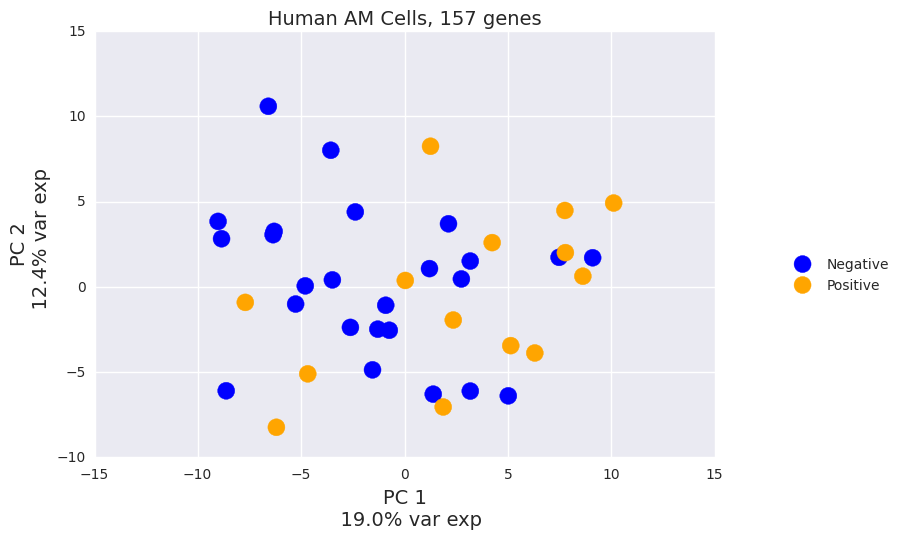

In [217]:
#limits = {'x':(-25,25),'y':(-30,30)}
limits = None
plot_pca(counts, meta, celltype='AM', PCs=[1,2], label_pseudomonas=True, 
         label_flu=True,
         size_col=None, size_label=False, size_scale=150,
         limits=limits, legend_loc='side', remove_outliers=1, 
         z_score=True, min_gene_count=10, min_uniques=1e6)


(46, 58051)
(46, 722)
removing outliers
30 55.368397689 2.84418335912
31 70.04230469 3.59795778365
[30, 31, 37]


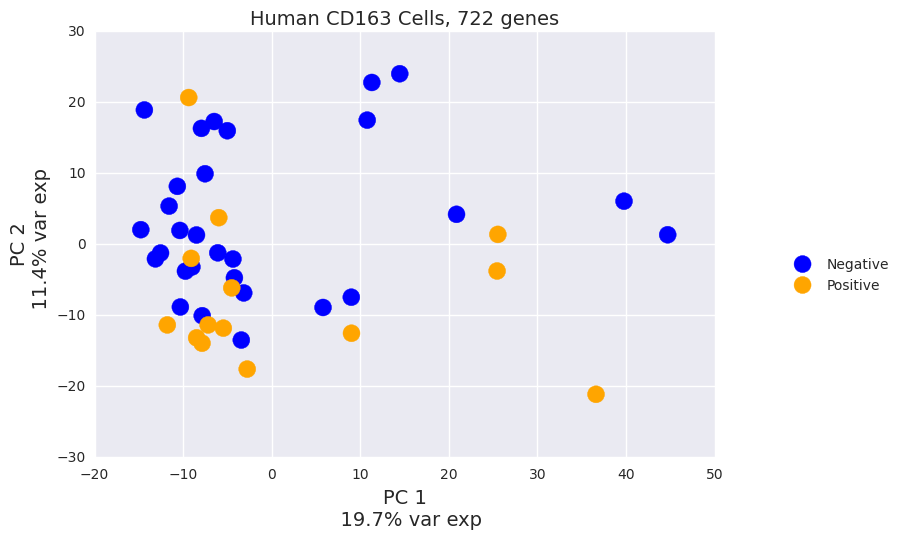

In [210]:
#limits = {'x':(-40,80),'y':(-40,80)}
limits = None
plot_pca(counts, meta, celltype='CD163', PCs=[1,2], label_pseudomonas=True, label_flu=True,
         size_col=None, size_label=False, size_scale=150,
         limits=limits, legend_loc='side', remove_outliers=1, z_score=False,
         min_gene_count=1, min_uniques=0)


PCi [0, 1]


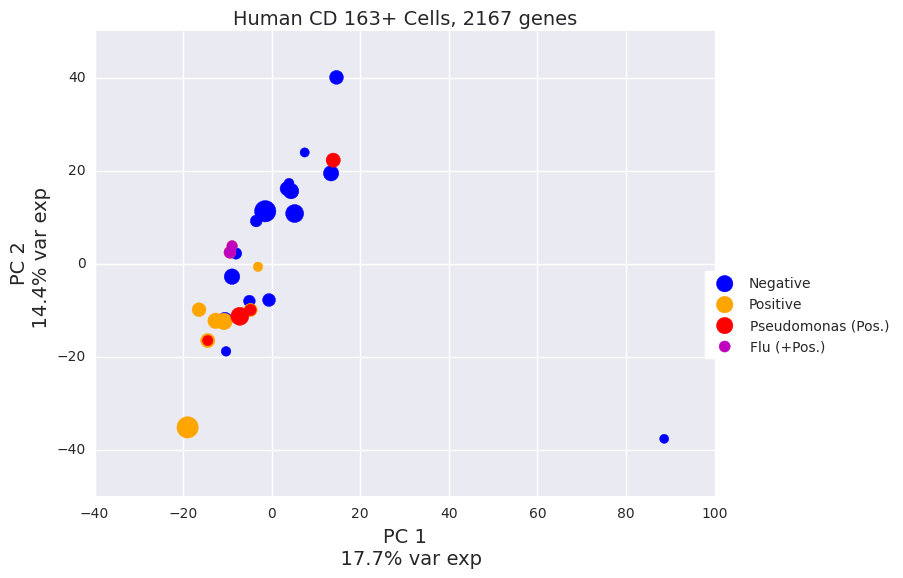

In [94]:
#limits = {'x':(-25,180),'y':(-40,80)}
#limits = {'x':(-25,15),'y':(-40,30)}
#limits=None
plot_pca(celltype='CD 163+', PCs=[1,2], label_pseudomonas=True, label_flu=True, 
         size_col='Apache mortality prediction',
         size_label=False,
         limits=limits, legend_loc='side')

In [64]:
df = dfAM
dfm = dfm0.ix[df.index]
non_out_AM = get_non_outlier_indices(dfAM)
dfAMin = dfAM.ix[non_out_AM]
dfm = dfm.ix[non_out_AM]

In [66]:
dfplot = dfAMin.T

In [70]:
dfplot = dfplot.rename(columns={c: dfm.loc[c,'Pneum'] for c in dfplot.columns})

In [158]:
import seaborn as sns
def plot_cluster(counts, meta, celltype, rem_loners=False, min_gene_count=0, min_uniques=0):
    
    dfm = meta[meta['CellType']==celltype]
    df = counts.ix[dfm.index]
    print df.shape, "original"
    df,dfm = filter_norm(df, dfm, celltype, min_gene_count, min_uniques)
    print df.shape, "after gene count, uniques filter"
    
    if celltype=='CD163':
        loners = ['BAL'+str(x) for x in [35, 18, 33, 84, 63, 34, 83]]
    if celltype=='AM':
        loners =['BAL'+str(x) for x in [89,83,66,17,76,86,21,35,79,85,84,38,28,55,75,87, 57, 74]] 
        
    if rem_loners:
        dfm = dfm[~dfm['BAL'].isin(loners)]
        df = df.ix[dfm.index]
    print df.shape, "after removing hand-picked loners"
    non_outliers = get_non_outlier_indices(df)

    dfin = df.ix[non_outliers]
    dfm = dfm.ix[non_outliers]

    dfz = dfin.apply(zscore, axis=1)
    dfz = dfz.apply(zscore, axis=0)

    dfplot = dfz.T
    print dfplot.shape, "after removing outliers"
    dfplot = dfplot.rename(columns={c: dfm.loc[c,'Pneum'] for c in dfplot.columns})

    dfplot.columns
    fig = sns.clustermap(dfplot, col_cluster=True)

    #pseud_BALs = ['BAL' + str(x) for x in [46, 49, 50, 75, 83]]
#meta['Pseudomonas'] = meta['BAL'].map(lambda x: True if x in pseud_BALs else False )
    

In [178]:
meta[meta['CellType']=='AM']['Pneum'].value_counts()

False    30
True     19
Name: Pneum, dtype: int64

(46, 58051) original
(43, 1186) after gene count, uniques filter
(43, 1186) after removing hand-picked loners
(1186, 41) after removing outliers


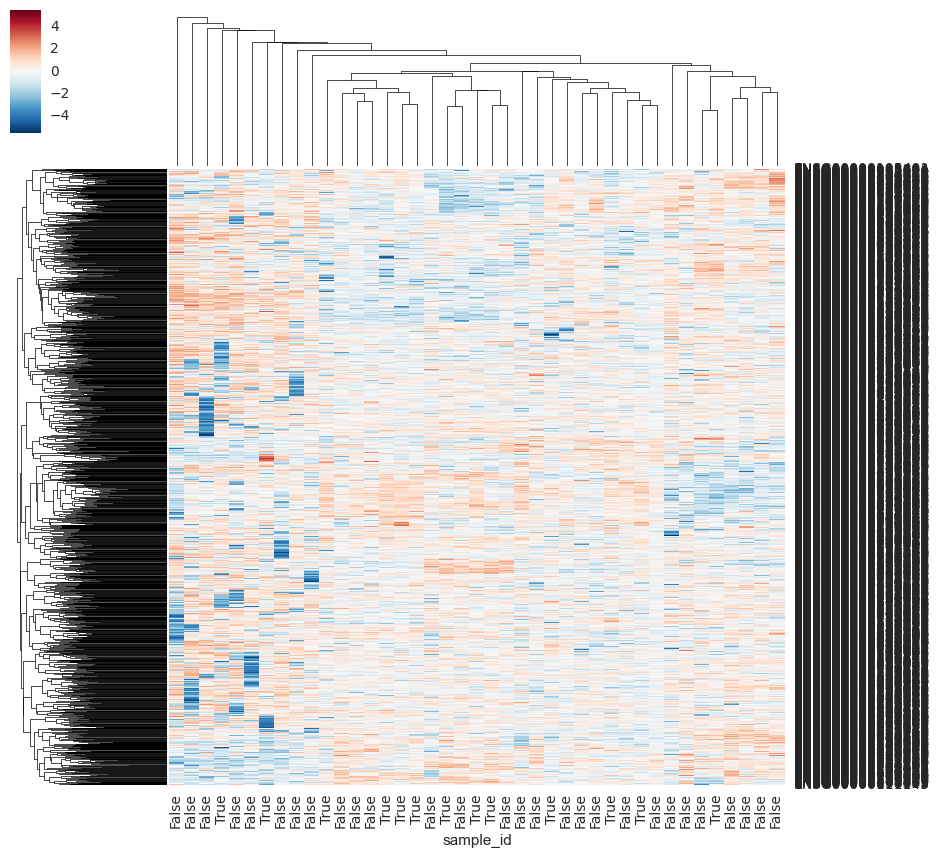

In [159]:
plot_cluster(counts, meta, 'CD163', rem_loners=False, min_gene_count=1, min_uniques=1e6)

(49, 58051) original
(44, 523) after gene count, uniques filter
(44, 523) after removing hand-picked loners
(523, 40) after removing outliers


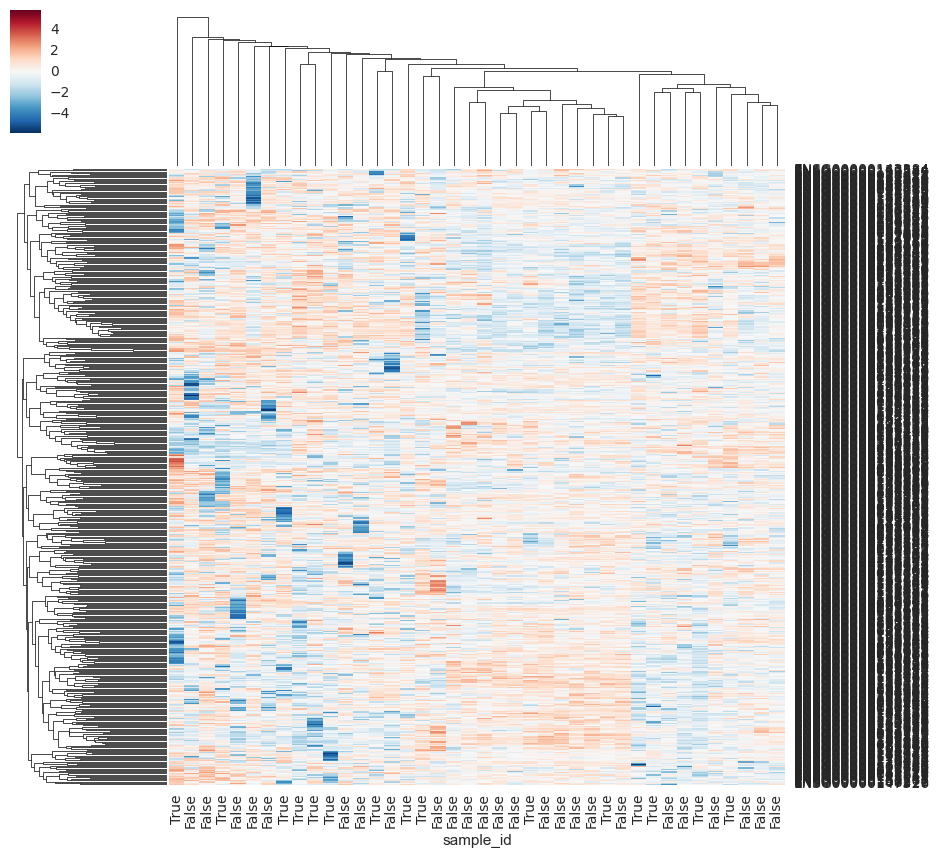

In [179]:
plot_cluster(counts, meta, 'AM', rem_loners=False, min_gene_count=1, min_uniques=1e6)

(49, 58051) original
(41, 1130) after gene count, uniques filter
(41, 1130) after removing hand-picked loners
(1130, 39) after removing outliers


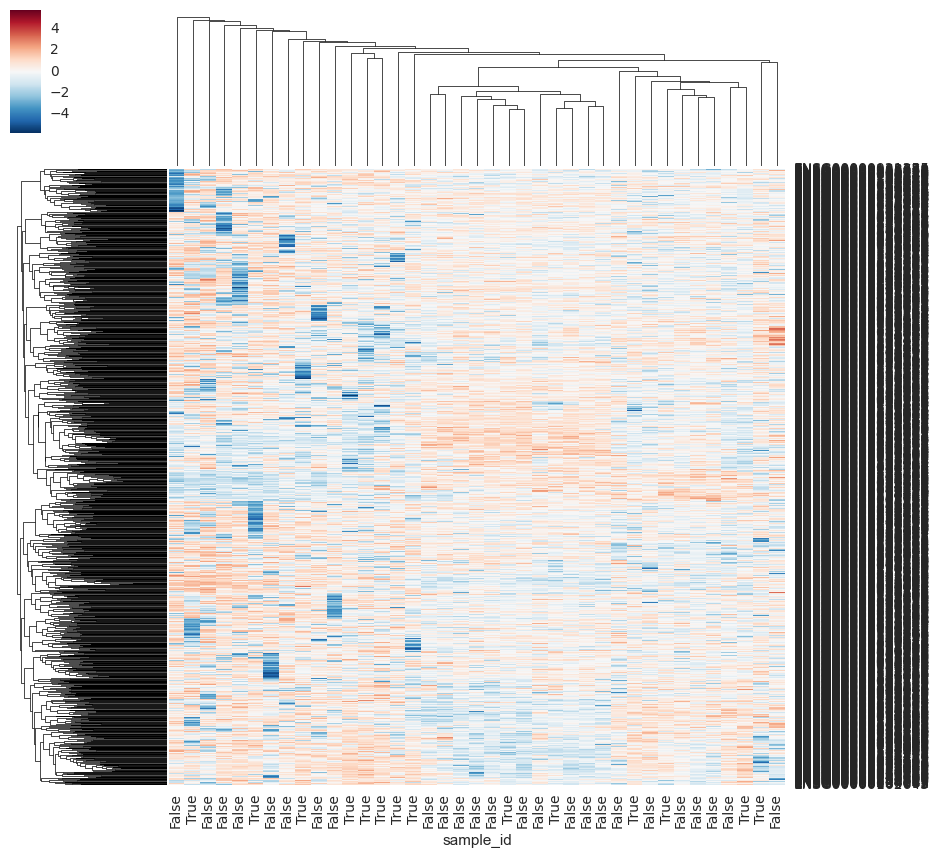

In [148]:
plot_cluster(counts, meta, 'AM', rem_loners=False, min_gene_count=1, min_uniques=4e6)

In [ ]:
loners = [89,83,66,17,76,86,21,35,79,85,84,38,28,55,75,87, 57, 74]

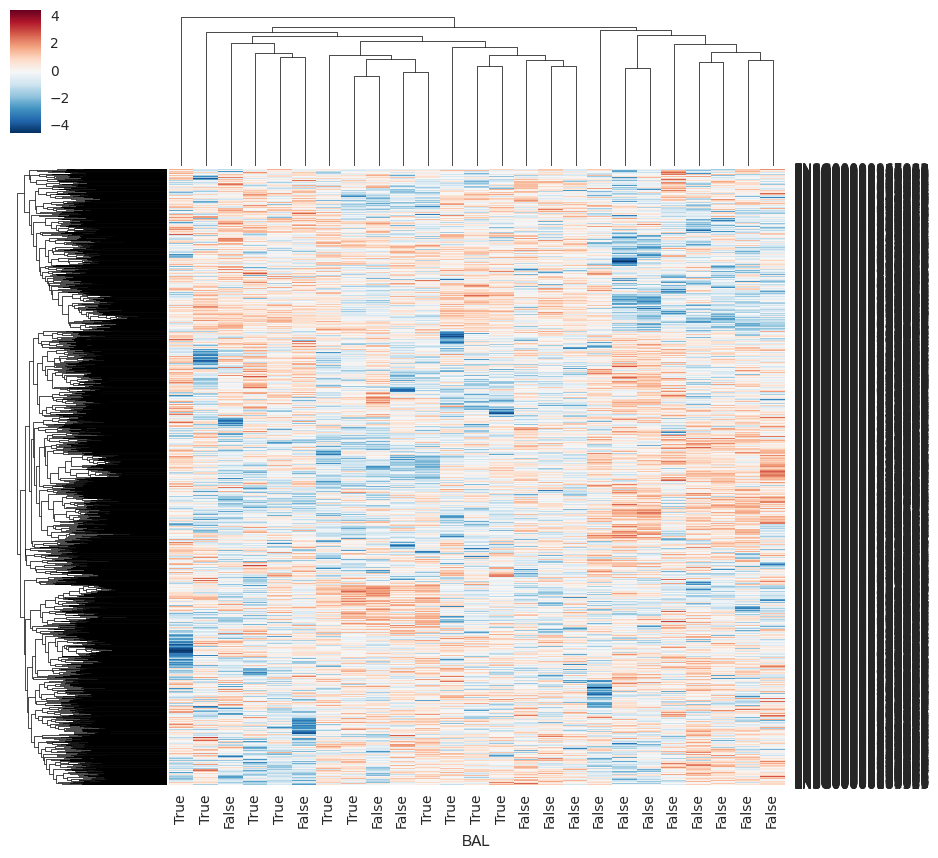

In [81]:
plot_cluster(df163)

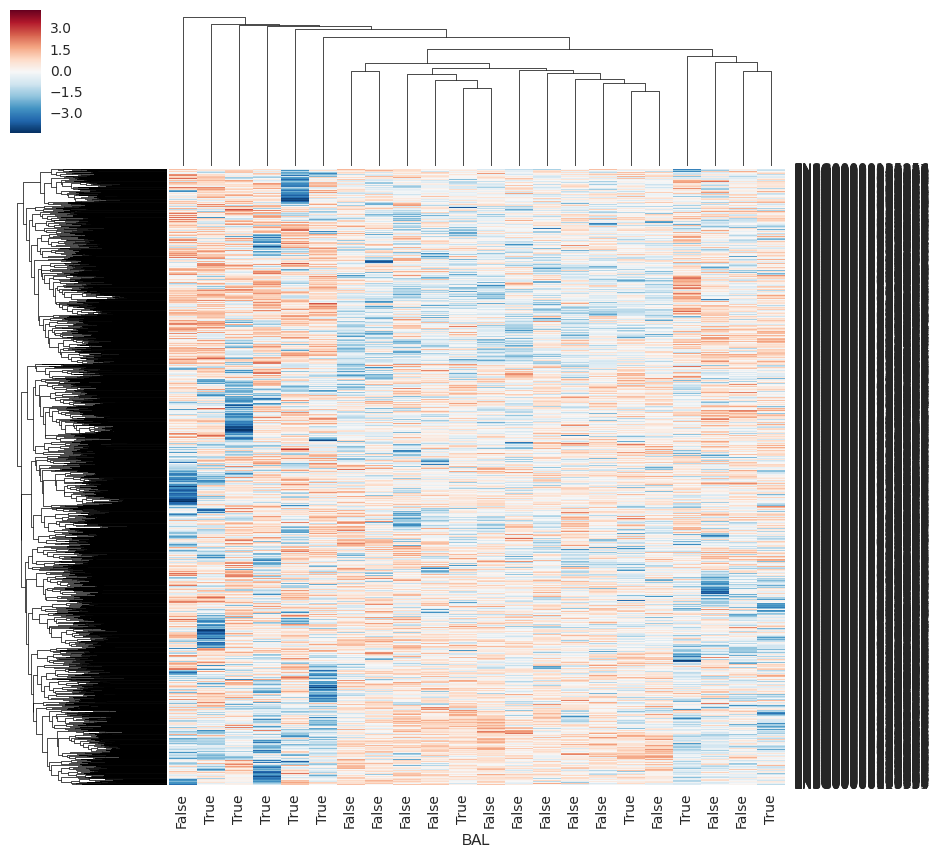

In [82]:
plot_cluster(dfAM)